### Evaluating the Mask R-CNN Torchscript model

In [1]:
from pycocotools.cocoeval import COCOeval
import numpy as np
from ceruleanml.inference import apply_conf_threshold_instances, apply_conf_threshold_masks
import torch
import torchvision
import skimage.io as skio
from pathlib import Path

In [2]:
model_path = "/slickformer/data/models/2023_02_18_00_38_07_4cls_rn152_pr512_px1024_1440min_maskrcnn_scripting_cpu_model.pt"
scripted_model = torch.jit.load(model_path)

### Grabbing a test image to inspect

In [3]:
test_scene = "S1A_IW_GRDH_1SDV_20210220T174437_20210220T174502_036677_044F60_51BC" # lots of slicks

data_dir = Path("../data/partitions/test_tiles_context_0/")

l = data_dir/"tiled_images"

imgs = list(l.glob("*"))

test_path = [i for i in imgs if test_scene in i.as_posix()][0]

### Drawing annotations from COCO onto image with PIL

In [4]:
from PIL import Image
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from pycocotools import mask as maskUtils

test_im_pil_channels = Image.open(test_path).split()

test_im_pil_vv = test_im_pil_channels[0]

#### Load annotations

In [5]:
with open(data_dir/"instances_CeruleanCOCO.json", 'r') as f:
    annotations = json.load(f)

scene_coco_record = [im_record for im_record in annotations['images'] if im_record['big_image_original_fname'] == test_scene+".tif"][0]

mask_arrs = []
annos = []
for anno in annotations['annotations']:
    if scene_coco_record['id'] == anno['image_id']:
        segment = anno['segmentation']
        # from the source, order is height then width https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/_mask.pyx#L288
        rle = maskUtils.frPyObjects(segment, anno['height'], anno['width'])
        mask_arrs.append(maskUtils.decode(rle))
        annos.append(anno)

#### Create a new image to draw on

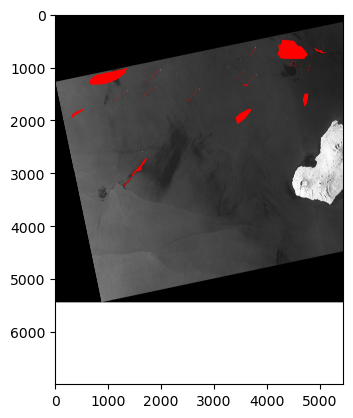

In [6]:
draw_img = Image.new('RGB', mask_arrs[0].shape, (255, 255, 255))

# Draw the image and polygons
draw = ImageDraw.Draw(draw_img)
draw.text((10, 10), 'Image', fill=(0, 0, 0))
draw_img.paste(test_im_pil_vv)
for poly in mask_arrs:
    rows, cols = np.where(poly)
    # Combine the row and column indices into (x, y) coordinate tuples
    coords = list(zip(cols, rows))
    draw.polygon(coords, outline=(255, 0, 0))

# Show the image with polygons
plt.imshow(np.array(draw_img))
plt.show()

Using the COCO API to interact with annotations. not all methods work and some result in memory errors with no clear github trail to follow. coco_dataset.showAnns() for example.

In [ ]:
from pycocotools.coco import COCO
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pycocotools import mask as maskUtils
test_scene = "S1A_IW_GRDH_1SDV_20210220T174437_20210220T174502_036677_044F60_51BC" # lots of slicks
data_dir = Path("../data/partitions/test_tiles_context_0/")
l = data_dir/"tiled_images"
imgs = list(l.glob("*"))
test_path = [i for i in imgs if test_scene in i.as_posix()][0]
test_im_pil_channels = Image.open(test_path).split()
test_im_pil_vv = test_im_pil_channels[0]

coco_annotation = COCO(annotation_file=data_dir/"instances_CeruleanCOCO.json")

img_info = coco_annotation.loadImgs([3000])[0]

# Get all the annotations for the specified image.
ann_ids = coco_annotation.getAnnIds(imgIds=[3000], iscrowd=None)
anns = coco_annotation.loadAnns(ann_ids)

# Save image and its labeled version.
plt.axis("off")
plt.imshow(np.asarray(test_im_pil_vv))
coco_annotation.showAnns(anns, draw_bbox=True)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


# TODO cleanup everything below

In [9]:
torch.Tensor(np.moveaxis(test_img,2,0)).shape

torch.Size([3, 224, 224])

And normalize the values to fall between 0 and 1

In [10]:
[torch.Tensor(np.moveaxis(test_img,2,0))/255]

[tensor([[[0.40000, 0.35294, 0.33333,  ..., 0.35294, 0.38431, 0.38824],
          [0.44706, 0.38431, 0.29804,  ..., 0.41569, 0.39608, 0.39216],
          [0.40000, 0.38824, 0.34118,  ..., 0.34902, 0.45882, 0.43529],
          ...,
          [0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
          [0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
          [0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000]],
 
         [[0.56078, 0.56078, 0.56078,  ..., 0.27843, 0.27451, 0.27451],
          [0.56471, 0.56078, 0.56078,  ..., 0.27843, 0.27843, 0.27843],
          [0.56471, 0.56471, 0.56078,  ..., 0.28235, 0.28235, 0.27843],
          ...,
          [0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
          [0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000],
          [0.00000, 0.00000, 0.00000,  ..., 0.00000, 0.00000, 0.00000]],
 
         [[0.00000, 0.00000, 0.00784,  ..., 0.00000, 0.00000, 0.00000],
          [0.00000, 0.00000,

Finally, we need to put each sample tensor in a list, the list length is the batch dimension.

In [11]:
len([torch.Tensor(np.moveaxis(test_img,2,0))/255])

1

maskrcnn wants a list of 3D arrays with length of list as batch size, Fastai Unet wants a 4D array with 0th dim as batch size

In [12]:
losses, pred_list = scripted_model([torch.Tensor(np.moveaxis(test_img,2,0))/255])

/root/work/.ice-env-inf/lib/python3.9/site-packages/torch/nn/modules/module.py:1102: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return forward_call(*input, **kwargs)
code/__torch__/torchvision/models/detection/mask_rcnn.py:107: UserWarning: RCNN always returns a (Losses, Detections) tuple in scripting


In [ ]:
len(pred_list)

1

pred_list details
* bbox coords are not normalized. 
* dict values are tensors until post processed with conf thresholding.
* length of value list indicates how many instances detected both low and high confidence
* Mask R-CNN mask values are not logits, they are 0 to 1 confidence probabilities. the torchscript model applies softmax unlike the fastai unet model where we do that after inference.
* bbox coord order is xmin, ymin, xmax, ymax, the same as icevision record collection bbox format

In [ ]:
pred_list[0]

{'boxes': tensor([[184.42181,  19.37008, 214.82938,  30.23640],
         [186.63612,  22.03430, 210.61983,  28.77451]], grad_fn=<StackBackward0>),
 'labels': tensor([2, 2]),
 'scores': tensor([0.99583, 0.06560], grad_fn=<IndexBackward0>),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], grad_fn=<UnsqueezeBackward0>)}

In [ ]:
pred_list[0]['scores']

tensor([0.99583, 0.06560], grad_fn=<IndexBackward0>)

In [ ]:
pred_list[0]['labels']

tensor([2, 2])

In [ ]:
pred_list[0]['masks'].shape

torch.Size([2, 1, 224, 224])

In [18]:
pred_list[0]['masks']

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], grad_fn=<UnsqueezeBackward0>)

In [19]:
%matplotlib inline
import skimage.io as skio

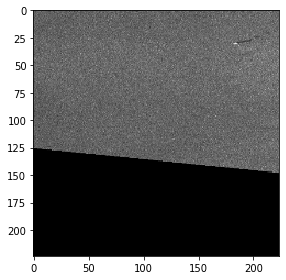

In [20]:
skio.imshow(test_img[:,:,0])

We can extract the first mask in the first sample's prediction and plot it by converting it to a numpy array.

/root/work/.ice-env-inf/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


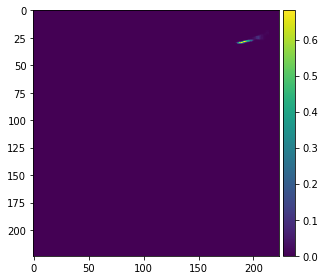

In [21]:
skio.imshow(pred_list[0]['masks'][0,0,:,:].detach().cpu().numpy())

TODO plot a histogram of confidence scores for a pred_list

In [22]:
import matplotlib.pyplot as plt

test = pred_list[0]['masks'][0,0,:,:].detach().cpu().numpy().flatten()

# scratch code
# np.ma.masked_where(test!=0, test)

# plt.hist(np.ma.masked_where(test!=0, test), bins = 300)

After inference, we need to post process the result.

In [23]:
bbox_conf_threshold = .5

pred_dict = apply_conf_threshold_instances(pred_list[0], bbox_conf_threshold=bbox_conf_threshold)

In [24]:
apply_conf_threshold_instances??

Signature: apply_conf_threshold_instances(pred_dict, bbox_conf_threshold)
Source:   
def apply_conf_threshold_instances(pred_dict, bbox_conf_threshold):
    """Apply a confidence threshold to the output of logits_to_classes for a tile.
    Args:
        pred_dict (dict): a dict with (for example):

        {'boxes': tensor([[  0.00000,  14.11488, 206.41418, 210.23907],
          [ 66.99806, 119.41994, 107.67549, 224.00000],
          [ 47.37723,  41.04019, 122.53947, 224.00000]], grad_fn=<StackBackward0>),
        'labels': tensor([2, 2, 2]),
        'scores': tensor([0.99992, 0.99763, 0.22231], grad_fn=<IndexBackward0>),
        'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
                    [0., 0., 0.,  ..., 0., 0., 0.],
                    [0., 0., 0.,  ..., 0., 0., 0.],
                    ...,
                    [0., 0., 0.,  ..., 0., 0., 0.],
                    [0., 0., 0.,  ..., 0., 0., 0.],
                    [0., 0., 0.,  ..., 0., 0., 0.]]],


                [[[0.,

In [25]:
pred_dict

{'boxes': [tensor([184.42181,  19.37008, 214.82938,  30.23640], grad_fn=<SelectBackward0>)],
 'labels': [tensor(2)],
 'scores': [tensor(0.99583, grad_fn=<SelectBackward0>)],
 'masks': [tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<SelectBackward0>)]}

In [26]:
merged_class_arr = apply_conf_threshold_masks(pred_dict, mask_conf_threshold=.05, size=224)

In [27]:
apply_conf_threshold_masks??

Signature: apply_conf_threshold_masks(pred_dict, mask_conf_threshold, size)
Source:   
def apply_conf_threshold_masks(pred_dict, mask_conf_threshold, size):
    """Apply a confidence threshold to the output of apply_conf_threshold_instances on the masks to get class masks.
    Args:
        pred_dict (dict): a dict with {'boxes':[], 'labels':[], 'scores':[], 'masks':[]}
        classes (np.ndarray): an array of shape [H, W] of class integers for the max confidence scores for each pixel
        conf_threshold (float): the threshold to use to determine whether a pixel is background or maximally confident category
    Returns:
        torch.Tensor: An array of shape [H,W] with the class ids that satisfy the confidence threshold. This can be vectorized.
    """
    high_conf_classes = []
    if len(pred_dict["masks"]) > 0:
        for i, mask in enumerate(pred_dict["masks"]):
            classes = torch.ones_like(mask) * pred_dict["labels"][i]
            classes = classes.long().squeeze()

The output of the last thresholding step is a 2D array of classes. we use this for pixel-wise evaluation. 

In [28]:
merged_class_arr.shape

torch.Size([224, 224])

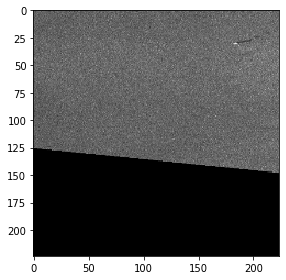

In [29]:
skio.imshow(test_img[:,:,0])

In [30]:
torch.unique(merged_class_arr)

tensor([0, 2])

In [31]:
import skimage.io as skio

This array has two values, 2 for vessels and 0 for background

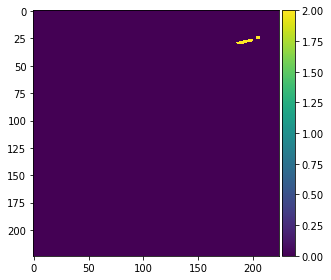

In [32]:
%matplotlib inline
skio.imshow(merged_class_arr.detach().cpu().numpy())

Next, we set up the data loader.

## Confusion Matrix Comparison for Unet and MaskRCNN

In this section we create and compare pixel-wise confusion matrices and instance-wise confusion matrices.

In [49]:
from ceruleanml.evaluation import get_cm_for_torchscript_model_unet, get_cm_for_torchscript_model_mrcnn
from ceruleanml.data import class_mapping_coco
from icevision.metrics.confusion_matrix import SimpleConfusionMatrix
from icevision.metrics.confusion_matrix.confusion_matrix import MatchingPolicy
from icevision.models.checkpoint import model_from_checkpoint

The pixel wise mrcnn cm is correct. TODO this doesn't work with negative samples, only the instance confusion matrix does.

In [49]:
get_cm_for_torchscript_model_mrcnn??

Signature:
get_cm_for_torchscript_model_mrcnn(
    valid_ds,
    model,
    save_path,
    mask_conf_threshold,
    bbox_conf_threshold,
    num_classes,
    normalize=None,
    class_names=None,
    title='Confusion Matrix',
)
Source:   
def get_cm_for_torchscript_model_mrcnn(
    valid_ds,
    model,
    save_path,
    mask_conf_threshold,
    bbox_conf_threshold,
    num_classes,
    normalize=None,
    class_names=None,
    title="Confusion Matrix",
):
    """
    TODO docstring
    the torchscript model when it is loaded operates on batches, not individual images
    this doesn't support eval on negative samples if they are in the dls,
    since val masks don't exist with neg samples. need to be constructed with np.zeros

    returns cm and f1 score
    """
    val_arrs = []
    class_preds = []
    for record in tqdm(valid_ds):
        masks_gt = []
        for i, label_id in enumerate(record.detection.label_ids):
            masks_gt.append(record.detection.mask_array.data[i] * 

In [ ]:
from tqdm import tqdm
cm_mrcnn, f1_mrcnn = get_cm_for_torchscript_model_mrcnn(
    valid_ds, scripted_model, save_path=icevision_experiment_dir, mask_conf_threshold=.01, bbox_conf_threshold=.7, num_classes=3, normalize=None, class_names=["background", "infra_slick", "recent_vessel"], title="Torchvision MaskR-CNN Confusion Matrix: 20_Jul_2022_00_14_15"
)


In [ ]:
cm_mrcnn, f1_mrcnn = get_cm_for_torchscript_model_mrcnn(
    valid_ds, scripted_model, save_path=icevision_experiment_dir, mask_conf_threshold=.01, bbox_conf_threshold=.7, num_classes=3, normalize="true", class_names=["background", "infra_slick", "recent_vessel"], title="Torchvision MaskR-CNN Confusion Matrix: 20_Jul_2022_00_14_15"
)


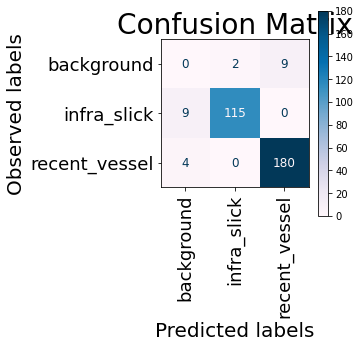

In [55]:
%matplotlib inline
_ = cm.finalize()

cm.plot(figsize=5, normalize=None)

In [ ]:
S1A_IW_GRDH_1SDV_20200724T020738_20200724T020804_033590_03E494_B457"